<a href="https://colab.research.google.com/github/LalitaDeelert/NLP-ZH_TH-Project/blob/main/notebooks/huggingface_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretraining Seq2Seq with MarianMT and HuggingFace

In [1]:
# !pip -q install datasets transformers==4.6.0 sentencepiece pythainlp
#install sacrebleu with thai
# !pip uninstall -q sacrebleu
# !pip install -q git+https://github.com/cstorm125/sacrebleu.git@add_thai_tokenizer

In [9]:
import transformers
import sentencepiece as spm
transformers.__version__

'4.6.0'

This notebook details how to pretrain a seq2seq model with `MarianMT` model using HuggingFace. In this example, we will train a `zh_cn` to `th` machine translation model using `open_subtitles` data. We refer to [`Helsinki-NLP/opus-mt-en-ro`](https://huggingface.co/Helsinki-NLP/opus-mt-en-ro) checkpoint as basis for our pretraining. The notebook is adapted from [Transformers Notebooks](https://github.com/huggingface/notebooks/blob/master/examples/translation.ipynb).

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`. We use the `zh_cn`/`th` part of the `open_subtitles` dataset.

In [10]:
from datasets import load_dataset, load_metric, Dataset, DatasetDict

metric = load_metric("sacrebleu")

In [11]:
import pandas as pd

#load data from csv
df = pd.read_csv('../data/v1/Train.csv')
df.tail()

,zh,th
1237445,我希望他们能忍受比那更少的游戏价值并且不要那么贵。,￼ชั้นหวังว่าพวกเขาจะประเมินราคาของเกมให้น้อยกว...
1237446,希望他们能修复它，因为图片很棒。,￼หวังว่าพวกเขาจะแก้ไขมันเพราะรูปภาพนั้นสําคัญค่ะ
1237447,刚把我的充电器从充电器上取下来，它似乎充电正常，然后当我今天早上坐在电脑前时突然放电。,￼เพิ่งถอดสายชาร์จออกค่ะ และมันดูเหมือนว่าจะชาร...
1237448,礼仪造就人。,���ารยาทสร้างคน
1237449,😢 唯一缺少的就是这个，屏幕封面也有:) 喜欢它的外观！总的来说，对它非常满意！,😢 อย่างเดียวที่ขาดไปน่าจะเป็นอะไรที่ช่วยปิดจอค...


In [12]:
#convert to dictionary
j = {'translation':[]}
for i in df.itertuples():
    j['translation'] += [{'zh_cn':i[1], 'th':i[2]}]

In [13]:
#load into dataset
train_dataset = Dataset.from_dict(j)
raw_datasets = train_dataset.train_test_split(test_size=0.01, seed=42)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1225075
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 12375
    })
})

To access an actual element, you need to select a split first, then give an index:

In [14]:
raw_datasets["train"][0]

{'translation': {'th': 'กางเกงยีนส์ฉันคับแล้วเนี่ย', 'zh_cn': '最近胖到牛仔裤都穿不下'}}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [15]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks]['translation'])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [16]:
show_random_elements(raw_datasets["train"])

,th,zh_cn
0,ไม่ใช่ว่าไม่มีโครงเรื่องความลุ่มลึกอะไรนะแต่มันเหมือนอยู่ๆก็จบ,并不是说它没有情节或深度，故事只是停止了。
1,จีนสร้างเกาะเทียมขึ้นในพื้นที่ขนาดใหญ่ที่อุดมไปด้วยทรัพยากรทําให้เหล่าประเทศเพื่อนบ้านเกิดความหวาดกลัว ญี่ปุ่นได้เพิ่มความร่วมมือด้านการป้องกันกับฟิลิปปินส์และดําเนินการฝึกร่วมกันในพื้นที่ พล.อ.นาคาทานิ รัฐมนตรีว่าการกระทรวงกลาโหมระบุว่า ญี่ปุ่นอาจส่งเครื่องบินลาดตระเวนไปยังภูมิภาคนั้นหากกฎหมายได้รับการอนุมัติ แต่ไม่ได้เปิดเผยถึงแผนการอื่นใดที่เฉพาะเจาะจง,中国一直在资源丰富的广袤地区建造人工岛，令周边国家感到震惊。日本加强了与菲律宾的防务合作，并在该地区进行了联合演习。日本防卫大臣中谷将军表示，如果立法获得批准，日本可以向该地区派遣侦察机，但他否认了任何具体计划。
2,และข้าอยากจะช่วย,我想帮你
3,ข้าอยากจะขอบคุณท่าน ไกอัส,我要感谢你，盖乌斯。
4,หนูแค่ยังไม่พร้อม หนูไม่รู้ว่าหนูคือใคร,我只是还没准备好。我不知道我是谁。


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [17]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: The system stream (a sequence of segments)
    references: A list of one or more reference streams (each a sequence of segments)
    smooth: The smoothing method to use
    smooth_value: For 'floor' smoothing, the floor to use
    force: Ignore data that looks already tokenized
    lowercase: Lowercase the data
    tokenize: The tokenizer to use
Returns:
    'score': BLEU score,
    'counts': Counts,
    'totals': Totals,
    'precisions': Precisions,
    'bp': Brevity penalty,
    'sys_len': predictions length,
    'ref_len': reference length,
Examples:

    >>> predictions = ["hello there general kenobi", "foo bar foobar"]
    >>> references = [["hello there gen

You can call its `compute` method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [18]:
fake_preds = ["hello there general kenobi"]
fake_labels = [["hello there general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'score': 100.00000000000004,
 'counts': [4, 3, 2, 1],
 'totals': [4, 3, 2, 1],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

## Train Tokenizer with `sentencepiece`

`MarianMT` requires 2 `sentencepiece` tokenizers for `source.spm` and `target.spm` languages. We will use the same tokenizer trained on both languages for this.

Save training set to text files for tokenizer training.

In [19]:
train_df = pd.DataFrame(raw_datasets['train']['translation'])

In [13]:
# #zh_cn
# train_df['zh_cn'].to_csv('zh_cn_tokenizer_train.txt',header=None,index=None)

# #th
# train_df['th'].to_csv('th_tokenizer_train.txt',header=None,index=None)

#both languages
train_df.to_csv('zh_cn_th_tokenizer_train.txt',header=None, index=None, sep='\n')

In [14]:
vocab_size = 32000 #choose what you want
user_defined_symbols = '<pad>'
vocab_special_size = vocab_size + len(user_defined_symbols)

#train tokenizer
def train_spm_tokenizer(train_fname, 
                        model_prefix,
                        vocab_special_size,
                        model_dir,
                        character_coverage=0.9995,
                        max_sentencepiece_length=16,
                        add_dummy_prefix='false',
                        model_type='unigram',
                        user_defined_symbols='<pad>'):
    sp = spm.SentencePieceProcessor()
    spm.SentencePieceTrainer.train((f'--input={train_fname} '
                                   f'--model_prefix={model_prefix} '
                                   f'--vocab_size={vocab_special_size} '
                                   f'--character_coverage={character_coverage} '
                                   f'--max_sentencepiece_length={max_sentencepiece_length} '
                                   f'--add_dummy_prefix={add_dummy_prefix} '
                                   f'--model_type={model_type} '
                                   f'--user_defined_symbols={user_defined_symbols}'))
    !mkdir $model_dir; mv $model_prefix* $model_dir

In [15]:
# #train zh_cn spm
# train_spm_tokenizer(train_fname='zh_cn_tokenizer_train.txt',
#                     model_prefix='source',
#                     vocab_special_size=vocab_special_size, #+1 for <pad>
#                     model_dir='marian-mt-zh_cn-th'
#                    ) 

# #train th spm
# train_spm_tokenizer(train_fname='th_tokenizer_train.txt',
#                     model_prefix='target',
#                     vocab_special_size=vocab_special_size, #+1 for <pad>
#                     model_dir='marian-mt-zh_cn-th'
#                    ) 

#train both spm
train_spm_tokenizer(train_fname='zh_cn_th_tokenizer_train.txt',
                    model_prefix='both',
                    vocab_special_size=vocab_special_size,
                    model_dir='marian-mt-zh_cn-th'
                   ) 

#copy both.model to source.spm and target.spm for marianmt tokenizer
!cp marian-mt-zh_cn-th/both.model marian-mt-zh_cn-th/source.spm
!cp marian-mt-zh_cn-th/both.model marian-mt-zh_cn-th/target.spm

mkdir: cannot create directory ‘marian-mt-zh_cn-th’: File exists


In [20]:
#load tokenizer
sp = spm.SentencePieceProcessor()
sp.load('marian-mt-zh_cn-th/both.model')

True

In [21]:
sp.encode_as_pieces('和别人一起来吗? สวัสดีครับพี่น้อง')

['和', '别人', '一起', '来', '吗', '?', '▁', 'สวัสดีครับ', 'พี่น้อง']

In [23]:
train_df.th.map(lambda x: len(sp.encode_as_pieces(x))).describe()

count    1.225075e+06
mean     1.389428e+01
std      1.886827e+01
min      1.000000e+00
25%      6.000000e+00
50%      9.000000e+00
75%      1.500000e+01
max      3.620000e+02
Name: th, dtype: float64

<AxesSubplot:>

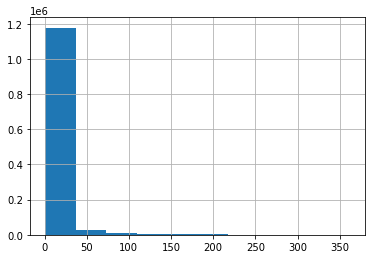

In [26]:
train_df.th.map(lambda x: len(sp.encode_as_pieces(x))).hist()

In [25]:
train_df.zh_cn.map(lambda x: len(sp.encode_as_pieces(x))).describe()

count    1.225075e+06
mean     1.422530e+01
std      1.793655e+01
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      3.290000e+02
Name: zh_cn, dtype: float64

<AxesSubplot:>

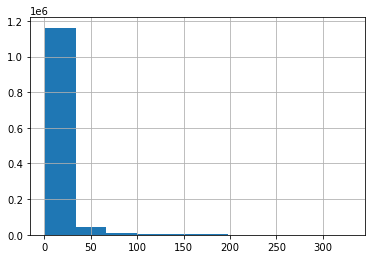

In [27]:
train_df.zh_cn.map(lambda x: len(sp.encode_as_pieces(x))).hist()

`MarianMT` also requires `vocab.json` with all vocab.

In [16]:
import json

#read vocab
with open('marian-mt-zh_cn-th/both.vocab','r') as f:
    vocab_lines = f.readlines()
vocab_lines[:10]
vocab_dict = {j.split('\t')[0]:i for i,j in enumerate(vocab_lines)}

In [17]:
#save vocab
with open('marian-mt-zh_cn-th/vocab.json','w') as f:
    json.dump(vocab_dict,f)

## Preprocessing the data

Once we have trained the `sentencepiece` tokenizer and all the necessary preparations, we can load the tokenizer as follows.

In [18]:
from transformers import MarianTokenizer
tokenizer = MarianTokenizer.from_pretrained('marian-mt-zh_cn-th')

You can directly call this tokenizer on one sentence or a pair of sentences:

In [19]:
tokenizer("สวัสดีครับ นี่ประโยคเดียว")

{'input_ids': [18748, 1237, 6525, 508, 2], 'attention_mask': [1, 1, 1, 1, 1]}

In [20]:
tokenizer.decode(tokenizer("สวัสดีครับ นี่ประโยคเดียว").input_ids)

'สวัสดีครับ นี่ประโยคเดียว'

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Instead of one sentence, we can pass along a list of sentences:

In [21]:
tokenizer(["สวัสดีครับพี่น้อง", "你好兄弟"])

{'input_ids': [[18748, 5980, 2], [1481, 2064, 2]], 'attention_mask': [[1, 1, 1], [1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the `as_target_tokenizer` context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [22]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["สวัสดีครับพี่น้อง", "你好兄弟"]))

{'input_ids': [[18748, 5980, 2], [1481, 2064, 2]], 'attention_mask': [[1, 1, 1], [1, 1, 1]]}


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [23]:
max_input_length = 128
max_target_length = 128
source_lang = "zh_cn"
target_lang = "th"

def preprocess_function(examples, tokenizer, prefix=''):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [24]:
preprocess_function(raw_datasets['train'][:2], tokenizer)

{'input_ids': [[2532, 8314, 125, 9278, 131, 1111, 47, 248, 2], [162, 6, 100, 15975, 289, 3838, 221, 12056, 160, 6272, 6, 34, 717, 2281, 1746, 3242, 8, 102, 13892, 4, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[13251, 22, 27090, 25, 1495, 2], [1347, 1237, 642, 6055, 61, 3863, 1800, 9698, 1073, 2597, 483, 36, 5061, 11084, 9, 2082, 4514, 733, 19, 6163, 23525, 230, 2]]}

To apply this function on all the pairs of sentences in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [25]:
from functools import partial

tokenized_datasets = raw_datasets.map(partial(preprocess_function, tokenizer=tokenizer), 
                                      batched=True,)

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Pretraining the Model

In order to be able to pretrain the model from scratch we copy the `config.json` from [`Helsinki-NLP/opus-mt-en-ro`](https://huggingface.co/Helsinki-NLP/opus-mt-en-ro) and modify it as follows to save in `marian-mt-zh_cn-th`. The only parts you might need to change are:
```
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 3,
  "unk_token_id": 0,
  "decoder_start_token_id": 3,
  "vocab_size": 32001,
 ```

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the `AutoModelForSeq2SeqLM` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [2]:
from transformers import (
    MarianMTModel, 
    MarianConfig, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
)

# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
config = MarianConfig.from_pretrained('marian-mt-zh_cn-th')
model = MarianMTModel(config)

Note that  we don't get a warning like in our classification example. This means we used all the weights of the pretrained model and there is no randomly initialized head in this case.

To instantiate a `Seq2SeqTrainer`, we will need to define three more things. The most important is the [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [30]:
batch_size = 512
args = Seq2SeqTrainingArguments(
    "zh_cn-th-translation",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the cell and customize the weight decay. Since the `Seq2SeqTrainer` will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the `predict_with_generate` option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [31]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our `Seq2SeqTrainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [32]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

In [33]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"], 
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the `train` method:

In [34]:
trainer.train()

wandb: Currently logged in as: cstorm125 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


RuntimeError: CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 15.78 GiB total capacity; 14.24 GiB already allocated; 66.75 MiB free; 14.41 GiB reserved in total by PyTorch)

In [93]:
#save model
trainer.save_model('trained_model')

In [122]:
#infer sample sentence zh_cn to th
model.cpu()
src_text = [
    '我爱你',
    '国王有很多心事。我明白'
]
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

['"', '"']

Don't forget to [upload your model](https://huggingface.co/transformers/model_sharing.html) on the [🤗 Model Hub](https://huggingface.co/models). You can then use it only to generate results like the one shown in the first picture of this notebook!